In [65]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [66]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [67]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]

scikit-learn 在 0.20 後，提供了新的 API `fetch_openml` 來下載公開資料集。

In [68]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, data_home='~/scikit_learn_data')
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    print('error!')
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]
X, y = mnist["data"], mnist["target"]

讓我們取出其中一個數字，透過 matplotlib 畫出來看看。注意，在這裡要先把一維的資料 `reshape` 成 28*28

Saving figure digit_plot


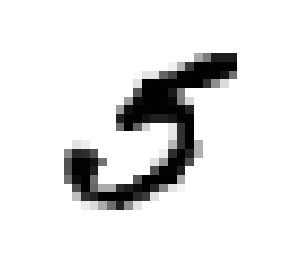

In [69]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("digit_plot")
plt.show()

In [70]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


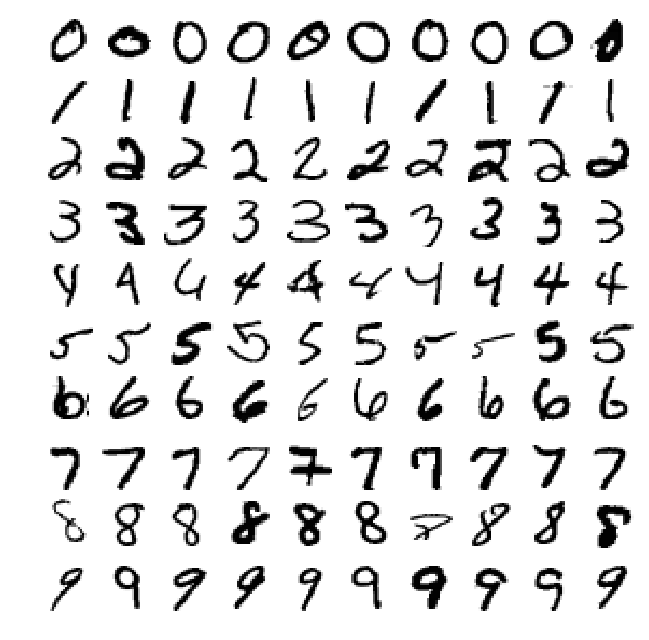

In [71]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

切 train/test 資料。前 60,000 筆是 training data，後 10,000 筆是 testing data

In [72]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print('Training data size: ', len(X_train))
print('Testing data size: ', len(X_test))

Training data size:  60000
Testing data size:  10000


打亂 training data 的順序

In [73]:
import numpy as np

shuffle_index = np.random.permutation(60000)
print(shuffle_index)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

[12628 37730 39991 ...   860 15795 56422]


## Binary Classification

這裡我們來練習 Binary Classification 用來辨識 mnist 的圖片是不是 5。先把 training 和 testing 的 y label 都改成 true/false。true 代表是 5，false 代表非 5

In [74]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [75]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

# lgr_clf = LogisticRegression()
# lgr_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [76]:
some_digit = X[0]

# predict some_digit by SGDClassifier trained in the previous step
sgd_result = sgd_clf.predict([some_digit])
print(sgd_result)

# predict some_digit by LogisticRegression trained in the previous step
# lgr_result = lgr_clf.predict([some_digit])
# print(lgr_result)

[False]


sklearn 提供了 cross validation 的函式 cross_val_score，這裡我們用 cv=3，也就是 3-fold cross-validation。

In [77]:
from sklearn.model_selection import cross_val_score
sgd_cvs = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# lgr_cvs = cross_val_score(lgr_clf, X_train, y_train_5, cv=5, scoring="accuracy")
print(sgd_cvs)
# print(lgr_cvs)

[0.9502  0.96565 0.96495]


In [78]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


儘管我們上面訓練的分類器看起來 accuracy 好像已經很高了，但是事實上這樣真的就沒問題嗎？我們建立一個分類器，這個分類器永遠不會猜 5。

In [79]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

可以看到這個分類器的 accuracy 也是高達 90% 左右。所以並不是 SGDClassifier 的能力強，而是我們的資料的特性使然，MNIST 本來有 0~9 十類手寫數字，我們只判斷資料是不是 5，那麼標記為 5 的資料量和 “非5” 的比例就是1:9，所以即便是全部猜成是 “非5” 也可以得到90%的準確率。從這個小例子我們可以看出當樣本極其不均衡時，僅僅考慮 accuracy 是無法衡量一個分類器的好壞的。

In [80]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

In [81]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [82]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

In [83]:
y_train_perfect_predictions = y_train_5

In [84]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [85]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7687135020350381

In [86]:
recall_score(y_train_5, y_train_pred)

0.801328168234643

In [87]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555